In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2023/players.csv
/kaggle/input/nfl-big-data-bowl-2023/week6.csv
/kaggle/input/nfl-big-data-bowl-2023/week2.csv
/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2023/week3.csv
/kaggle/input/nfl-big-data-bowl-2023/week8.csv
/kaggle/input/nfl-big-data-bowl-2023/games.csv
/kaggle/input/nfl-big-data-bowl-2023/week5.csv
/kaggle/input/nfl-big-data-bowl-2023/week7.csv
/kaggle/input/nfl-big-data-bowl-2023/week1.csv
/kaggle/input/nfl-big-data-bowl-2023/week4.csv
/kaggle/input/nfl-big-data-bowl-2023/plays.csv


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

from prettytable import PrettyTable

#Get players function returns a dictionary of keys: gameID, playID, and the players on the field by position for 
# a given play keys: 'Rushers', 'Blockers', 'QB' and if the play was a trick or not key: 'Trick'. Rushers contains the stat 
# recorded for each rusher or none. Blockers contains the keys: block_assignment and block_type

def get_players(
    gameid: int,
    playid: int,
    data: pd.DataFrame,
) -> (dict):
    
    play_dict = {}
    
    play_data = data[(data['gameId'] == gameid) & (data['playId'] == playid)]
    
    pass_rushers = play_data[play_data['pff_role'] == 'Pass Rush']['nflId'].values
    pass_blockers = play_data[play_data['pff_role'] == 'Pass Block']['nflId'].values
    QB = play_data[play_data['pff_positionLinedUp'] == 'QB']['nflId'].values[0]
    
    rushers = {}
    if len(pass_rushers) == 0:
        rushers = None
    else:
        for i in pass_rushers:
            player = {}
            player_data = play_data[(play_data['nflId'] == i)]
            if player_data['pff_hit'].values[0] == 1:
                player['stats'] = 'hit'
                rushers[i] = player
                continue
            if player_data['pff_hurry'].values[0] == 1:
                player['stats'] = 'hurry'
                rushers[i] = player
                continue
            if player_data['pff_sack'].values[0] == 1:
                player['stats'] = 'sack'
                rushers[i] = player
                continue
            else:
                player['stats'] = 'none'
                rushers[i] = player
    
    blockers = {}
    for i in pass_blockers:
        player = {}
        player_data = play_data[(play_data['nflId'] == i)]
        block_type = player_data['pff_blockType'].values[0]
        block_assignment = player_data['pff_nflIdBlockedPlayer'].values[0]
        player['block_type'] = block_type
        player['block_assignment'] = block_assignment
        blockers[i] = player

    trick_play = 1 if QB != play_data[play_data['pff_role'] == 'Pass']['nflId'].values[0] else 0
    
    play_dict['game_id'] = gameid
    play_dict['play_id'] = playid
    play_dict['Rushers'] = rushers
    play_dict['Blockers'] = blockers
    play_dict['QB'] = QB
    play_dict['Trick'] = trick_play
    
    return play_dict

#Takes the dictionary for a play created by get_players --> returns a dictionary
# with appended information for each players. Each dicitonary has keys for the pass rushers on the field. The dictionary within each pass
# rusher key contains the keys 'distances', 'speeds', and 'accelerations'.
#Plays where the ball is released in less than 2 seconds are not included. 

def get_distances(
    dictionary: dict,
    data: pd.DataFrame
) -> (dict):
    
    dictionary = dictionary
    
    locations = data[(data['gameId'] == dictionary['game_id']) & (data['playId'] == dictionary['play_id'])].sort_values(by='frameId')
    
    snap_frame = locations[locations['event'].isin(['ball_snap', 'autoevent_ballsnap'])]['frameId'].values
    end_frame = locations[locations['event'].isin(['autoevent_passforward', 'autoevent_passinterrupted',
                                                   'lateral', 'run', 'qb_strip_sack', 'qb_sack', 'pass_forward',
                                                  ])]['frameId'].values
    
    if not len(snap_frame) or not len(end_frame):
        return None

    snap_frame = snap_frame[0]
    end_frame = end_frame[0]
    
    rush_time_length = end_frame - snap_frame
    dictionary['rush_time'] = rush_time_length

    filtered_loc = locations[(locations['frameId'] >= snap_frame) & (locations['frameId'] <= end_frame)]

    qb_locations = filtered_loc[(filtered_loc['nflId'] == dictionary['QB'])]
    qb_speed = [row['s'] for _, row in qb_locations.iterrows()]
    qbxy = [(row['x'], row['y']) for _, row in qb_locations.iterrows()]

    rusher_distances = {}
    
    if dictionary['Rushers'] == None:
            return dictionary

    for i in dictionary['Rushers']:            
        rusher_locations = filtered_loc[(filtered_loc['nflId'] == i)]  
        rusherxy = [(row['x'], row['y']) for _, row in rusher_locations.iterrows()]
        speed = [row['s'] for _, row in rusher_locations.iterrows()]
        distances = []
        for q in range(len(qbxy)):
            distance = np.sqrt(((qbxy[q][0]-rusherxy[q][0])**2)+((qbxy[q][1]-rusherxy[q][1])**2))
            distances.append(distance)
        dictionary['Rushers'][i]['Positional_data'] = {'distances': np.asarray(distances), 'speeds': np.asarray(speed), 'qb_speed': np.asarray(qb_speed)}
    
    
    return dictionary

# Summation of (1/D) * Speed for each frame
def pm1(distances: np.array, speeds: np.array
       ) -> (int):
    if distances is None:
        return None
    frame_values = []
    for i in range(len(distances)):
        value = (1/max([distances[i],.01]))* speeds[i]
        frame_values.append(value)
    return(sum(frame_values))

# Max Frame Value of (1/D) * Speed 
def pm2(distances: np.array, speeds: np.array
       ) -> (int):
    if distances is None:
        return None
    frame_values = []
    for i in range(len(distances)):
        value = (1/max([distances[i],.01]))* speeds[i]
        frame_values.append(value)
    return(max(frame_values))

# Summation of (1/D)* Speed * QB speed for each frame
def pm3(distances: np.array, speeds: np.array, qb_speeds: np.array
       ) -> (int):
    if distances is None:
        return None
    frame_values = []
    for i in range(len(distances)):
        value = (1/max([distances[i],.01]))* speeds[i] * qb_speeds[i]
        frame_values.append(value)
    return(sum(frame_values))

# Max Frame Value of (1/D)* Speed * QB speed
def pm4(distances: np.array, speeds: np.array, qb_speeds: np.array
       ) -> (int):
    if distances is None:
        return None
    frame_values = []
    for i in range(len(distances)):
        value = (1/max([distances[i],.01]))* speeds[i] * qb_speeds[i]
        frame_values.append(value)
    return(max(frame_values))

# Minimum Distance from QB
def pm5(distances: np.array
       ) -> (int):
    if distances is None:
        return None
    return(min(distances))

# Time to release
def pm6(distances: np.array
       ) -> (int):
    if distances is None:
        return None
    return(len(distances))

#Store the pff data the pff_data dataframe. This data will be used to get the QB and pass rusher ID for each play
#This data will be used as the data for the get_players() function to return QB, Rushers, OL, and trick/ no trick


pff_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv")

#Import play data
#'gameID' and 'playID' from this data will be used to loop through the pff_data with the get_players() function
#Visulaizations help us see how many plays are removed by only looking at Traditional and Scrambles

data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/plays.csv")

#Drop all pass plays except Traditional Drop Back and Scramble, excluding designed runs and designed roll outs
data = data[(data['dropBackType'].isin(['TRADITIONAL', 'SCRAMBLE']))]

#This cell creates a single dataframe (games_df) with all the positional data
#games_df will be used as the data in the get_distances() function
files = ['/kaggle/input/nfl-big-data-bowl-2023/week1.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week2.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week3.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week4.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week5.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week6.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week7.csv', 
         '/kaggle/input/nfl-big-data-bowl-2023/week8.csv']

games_df = pd.DataFrame()
for i in files:
    week_df = pd.read_csv(i)
    games_df = pd.concat([games_df, week_df], axis=0)
    
#Create List of Games and Plays 

games = data['gameId']
plays = data['playId']

#Save plays_data
plays_data = [get_players(gameid=game, playid=play, data=pff_data)
           for game, play in zip(games, plays)]

#Save play_data with positionals
plays_with_positional = [get_distances(dictionary=play_dict, data=games_df) for play_dict in plays_data]

#Create lists for the pass rushes data frame

rush_time_cutoff = 20
play_id = []
game_id = []
rusher_id = []
rush_instances = []
distances = []
speeds = []
qb_speeds = []
outcomes = []
counter = []
for i in plays_with_positional:
    if i == None:
        continue
    if i['Rushers'] == None:
        continue
    
    if i['rush_time'] >= rush_time_cutoff and i['Trick'] != 1:
        for j in i['Rushers']:
            outcomes.append(i['Rushers'][j]['stats'])
            distances.append(i['Rushers'][j]['Positional_data']['distances'])
            speeds.append(i['Rushers'][j]['Positional_data']['speeds'])
            qb_speeds.append(i['Rushers'][j]['Positional_data']['speeds'])
            rush_instances.append('Valid')
            counter.append(1)
            play_id.append(i['play_id'])
            game_id.append(i['game_id'])
            rusher_id.append(j)
    elif i['rush_time'] <= rush_time_cutoff:
        for j in i['Rushers']:
            outcomes.append(None)
            distances.append(None)
            speeds.append(None)
            qb_speeds.append(None)
            rush_instances.append('Short')
            counter.append(1)
            play_id.append(i['play_id'])
            game_id.append(i['game_id'])
            rusher_id.append(j)
    elif i['Trick'] == 1:
        for j in i['Rushers']:
            outcomes.append(None)
            distances.append(None)
            speeds.append(None)
            qb_speeds.append(None)
            rush_instances.append('Trick')
            counter.append(1)
            play_id.append(i['play_id'])
            game_id.append(i['game_id'])
            rusher_id.append(j)
            
#Transform positional data into predictor values for regression
pm1_values = []
pm2_values = []
pm3_values = []
pm4_values = []
pm5_values = []
pm6_values = []
for i in range(len(rush_instances)):
    pm1_values.append(pm1(distances=distances[i], speeds=speeds[i]))
    pm2_values.append(pm2(distances=distances[i], speeds=speeds[i]))
    pm3_values.append(pm3(distances=distances[i], speeds=speeds[i], qb_speeds=qb_speeds[i]))
    pm4_values.append(pm4(distances=distances[i], speeds=speeds[i], qb_speeds=qb_speeds[i]))
    pm5_values.append(pm5(distances=distances[i]))
    pm6_values.append(pm6(distances=distances[i]))

#Assemble full pass rushes dataframe
pass_rushes_df = pd.DataFrame(zip(game_id, play_id, rusher_id, pm1_values, pm2_values, pm3_values, pm4_values, pm5_values, pm6_values, np.asarray(rush_instances), np.asarray(distances), np.asarray(speeds), np.asarray(qb_speeds), np.asarray(outcomes), np.asarray(counter)),
               columns =['game_id', 'play_id','rusher_id','PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6','Rush Classifier', 'Distances', 'Speeds', 'Qb_speeds','Outcomes','counter'])


#Drop null values and select for valid plays to create regression dataframe
regression_data = pass_rushes_df.dropna(axis=0)[(pass_rushes_df['Rush Classifier'] == 'Valid')]

#Count outcome breakdown

total_observations = len(regression_data)
none_observations = regression_data.groupby('Outcomes').count()['counter'][2]
none_percent = round(none_observations/total_observations, 2)*100
hurry_observations = regression_data.groupby('Outcomes').count()['counter'][1]
hurry_percent = round(hurry_observations/total_observations, 2)*100
hit_observations = regression_data.groupby('Outcomes').count()['counter'][0]
hit_percent = round(hit_observations/total_observations, 2)*100
sack_observations = regression_data.groupby('Outcomes').count()['counter'][3]
sack_percent = round(sack_observations/total_observations, 2)*100

#Give numerical values to the outcomes
regression_data['Response'] = regression_data.apply(lambda row: 0 if row['Outcomes'] == "none" else (3 if row['Outcomes'] == 'hurry' else (4 if row['Outcomes'] == 'hit' else 5)) , axis=1)

#Split train and test
train_set, test_set = train_test_split(regression_data, test_size=0.2, random_state=120, shuffle=True)

#Assign predictor and response variables
predictors = ['PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6']
response = ['Response']

#Create train and test sets
x_train = train_set[predictors]
y_train = train_set[response]
x_test = test_set[predictors]
y_test = test_set[response]

#Loop through max_depths and choose the best test_mse to tune max depth hyperparameter
depths = [1,2,3,4,5,6,7,8,9,10]
depth_scores = {}
for i in depths:
    randomforest = RandomForestRegressor(n_estimators=300, max_features='sqrt', max_depth=i).fit(x_train,y_train);
    y_train_pred = randomforest.predict(x_train)
    y_test_pred = randomforest.predict(x_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    depth_scores[i] = {'test_mse': test_mse , 'train_mse': train_mse}
    
rf_test_mses = []
rf_train_mses = []
for i in depth_scores:
    rf_test_mses.append(depth_scores[i]['test_mse'])
    rf_train_mses.append(depth_scores[i]['train_mse'])
    
low_test_mse = min(rf_test_mses)
low_train_mse = rf_train_mses[rf_test_mses.index(low_test_mse)]
best_depth = rf_test_mses.index(low_test_mse)+1

#Train model based on best_depth hyper parameter
best_randomforest = RandomForestRegressor(n_estimators=300, max_features='sqrt', oob_score=True, max_depth=best_depth).fit(x_train,y_train)

#Create test predictions with best model
y_test_pred = best_randomforest.predict(x_test)

#Assemble full dataset with Random Forest Generated PRPM

randomforest_prpm = best_randomforest.predict(regression_data[predictors])
data_with_rfprpm = regression_data
data_with_rfprpm['randomforest_prpm'] = randomforest_prpm

#Attach Player Names to randomforest_prpm
players_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/players.csv')
listednflids = list(data_with_rfprpm['rusher_id'].values)
names = []
positions = []
for i in listednflids:
    player_row = players_data[players_data['nflId'] == i]
    name = player_row['displayName'].values[0]
    position = player_row['officialPosition'].values[0]
    names.append(name)
    positions.append(position)

data_with_rfprpm['name'] = names
data_with_rfprpm['position'] = positions



#Select for players that have more than 30 rushes on the year
data_with_rfprpm = data_with_rfprpm[data_with_rfprpm.groupby('name')['name'].transform('size') > 30]

#Separate the positions into DE, DT, and OLB
DE_rfprpm = data_with_rfprpm[data_with_rfprpm['position'] == 'DE'].groupby('name').mean().sort_values(by='randomforest_prpm', ascending=False)[['randomforest_prpm', 'rusher_id']]
DT_rfprpm = data_with_rfprpm[data_with_rfprpm['position'] == 'DT'].groupby('name').mean().sort_values(by='randomforest_prpm', ascending=False)[['randomforest_prpm', 'rusher_id']]
OLB_rfprpm = data_with_rfprpm[data_with_rfprpm['position'] == 'OLB'].groupby('name').mean().sort_values(by='randomforest_prpm', ascending=False)[['randomforest_prpm', 'rusher_id']]

DE_rfprpm['name'] = list(DE_rfprpm.index.values)
DT_rfprpm['name'] = list(DT_rfprpm.index.values)
OLB_rfprpm['name'] = list(OLB_rfprpm.index.values)

#Organize player stats over weeks 1-8
sack_sorted = pff_data.groupby('nflId').sum().sort_values(by='pff_sack', ascending = False).reset_index()
num_sacks = list(sack_sorted['pff_sack'])
sack_rank = list(sack_sorted.index.values+1)
top_ids = list(sack_sorted['nflId'].values)
sack_sorted_df = pd.DataFrame(zip(top_ids,sack_rank,num_sacks),
               columns =['nflId', 'sack_rank','num_sacks'])


hits_sorted = pff_data.groupby('nflId').sum().sort_values(by='pff_hit', ascending = False).reset_index()
num_hits = list(hits_sorted['pff_hit'])
hits_rank = list(hits_sorted.index.values+1)
top_ids = list(hits_sorted['nflId'].values)
hits_sorted_df =  pd.DataFrame(zip(top_ids,hits_rank,num_hits),
               columns =['nflId', 'hits_rank','num_hits'])

hurry_sorted = pff_data.groupby('nflId').sum().sort_values(by='pff_hurry', ascending = False).reset_index()
num_hurry = list(hurry_sorted['pff_hit'])
hurry_rank = list(hurry_sorted.index.values+1)
top_ids = list(hurry_sorted['nflId'].values)
hurry_sorted_df =  pd.DataFrame(zip(top_ids, hurry_rank, num_hurry),
               columns =['nflId', 'hurry_rank','num_hurries'])

#Merge Sacks and Hits into sack_hits
sack_hits = pd.merge(
    left=sack_sorted_df,
    right=hits_sorted_df,
    left_on='nflId',
    right_on='nflId',
    how='left'
)

#Merge sack_hits and hurry into player_stats_df
player_stats_df = pd.merge(
    left=sack_hits,
    right=hurry_sorted_df,
    left_on='nflId',
    right_on='nflId',
    how='left'
)

player_stats_df.head()

#Merge DE_rfprpm and player_stats_df into DE_stats
DE_stats = pd.merge(
    left=DE_rfprpm,
    right=player_stats_df,
    left_on='rusher_id',
    right_on='nflId',
    how='left',
)

#Merge DT_rfprpm and player_stats_df into DT_stats
DT_stats = pd.merge(
    left=DT_rfprpm,
    right=player_stats_df,
    left_on='rusher_id',
    right_on='nflId',
    how='left',
)

#Merge OLB_rfprpm and player_stats_df into OLB_stats
OLB_stats = pd.merge(
    left=OLB_rfprpm,
    right=player_stats_df,
    left_on='rusher_id',
    right_on='nflId',
    how='left',
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:311: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:345: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:345: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:345: DataConversionWarn

_____
## **Pass Rush Pressure Metric (PRPM)**: 
***A Machine-Learning Based Method for Assessing Pass Rusher Effectiveness***

By Maximilian Jones and Benjamin Zeisberg

Harvard College

## **1. Introduction**

Current methods for evaluating pass rushers lack a comprehensive and quantitative metric. Pro Football Focus (PFF) grades rushers based on if they win their block and how quickly they do so and records several stats such as hurries, hits, and sacks${^1}$. PFF grades are the most comprehensive way to measure pass rushers but require manual grading and often are scrutinized for their subjectivity. 

PFF’s pass-rush productivity metric measures pressure on a per-snap basis with a weighting toward sacks${^2}$; ESPN defines rushers' performance based on their "Win Rate," or how often they beat their block within 2.5 seconds${^3}$, while Stats Perform measures "Pressure Rate," or how often a defender gets into the backfield and has an unabated path to the quarterback${^4}$. Not all sacks are equally impressive–hits and hurries alike– and while these metrics provide some insight into pass-rusher performance, they fail to distinguish between plays with the same statistical outcome and overlook plays where a rusher doesn’t record a statistic. 

**To address this gap in pass-rush evaluation, we propose the Pass Rush Pressure Metric (PRPM), a continuous quantitative metric that scores a rusher on every pass play. Derived from player positional data, PRPM aims to provide a more comprehensive method for assessing pass-rusher efficiency without the need for manual grading.**

______
## **2. Random Forest Regressor Generated PRPM**

**2.1 Overview**

To generate the pass rush pressure metric, we use a Random Forest Regressor, an ensemble method for regression. Based on the pass rusher’s euclidian distance from quarterback and speed, and the quarterback’s speed for each frame between the snap and end of the pass attempt the model predicts the outcome of the pass rush on a scale from 0-5, 0 being the least effective rush and 5 being the most effective rush. The regression assigns the values 0, 3, 4, and 5 to the possible outcomes none, hurry, hit, and sack, respectively. Values were assigned based on the perceived importance of each stat, none being worthless and sacks being worth the most. Since sklearn’s Random Forest Regressors cannot handle array data as predictors, we performed several transformations on the positional data for each play and used those as predictors (see 2.1 Data Pre-processing). The weak learners (trees) in this model create hundreds of predictions for the result of a pass rush based on a rusher and quarterback’s movements. When combined, these weak learners provide a strong predictive metric, ranging from 0-5, representing the effectiveness of a pass rush attempt.

**2.2 Data Pre Processing**

To gather the data, we looped through every play of every game listed in the plays.csv file and used the pffScoutingData.csv file to pull the nflId of all pass rushers and quarterbacks. With the nflId of all relevant players, we looped through players for each play and pulled the euclidian distance from the quarterback and speed for pass rushers and speed for Quarterbacks. This function only pulled the positional and speed data between the snap and end of the pass attempt (sack, rush, or ball release) – we focused our analysis on this time because that pre-snap and post-pass movements are not important for measuring pass rush pressure. 

Rows with null values and observations where the time between snap and end of the pass attempt was less than two seconds were removed from the data. We removed these shorter observations to eliminate screen passes, quick passes, and other plays where a rusher doesn’t have sufficient time to produce an effective pass rush. The remaining observations are shown in figure 1. 

In [3]:
# Print Observation Breakdown
print(
    "Figure 1: Processed Data Makeup \n\nThe data set contained {} observations:\n\n\tNone\t{} ({}%)\n\tHurry\t{} ({}%)\n\tHit\t{} ({}%)\n\tSack\t{} ({}%)"
    .format(
        total_observations,
        none_observations,
        none_percent,
        hurry_observations,
        hurry_percent,
        hit_observations,
        hit_percent,
        sack_observations,
        sack_percent,
    )
)

Figure 1: Processed Data Makeup 

The data set contained 27874 observations:

	None	24315 (87.0%)
	Hurry	2327 (8.0%)
	Hit	691 (2.0%)
	Sack	541 (2.0%)


Since Random Forest Regressors can’t handle array data as predictors, we derived 6 values from the positional data that contain information about the pass rush and intuitively describe its effectiveness these values, PM1-6, are shown in Figure 2.

Figure 2: PM1-6 Transformations for Positional Data

- $PM_1 = \sum_{f=1}^{f=z} (\frac{1}{d^2} * s) $
    - where $d$ = Distance to Quarterback, $s$ = Speed, $z$ = Frame
    - PM1 represents the speed that a rusher is moving, weighted by their proximity to the quarterback. Intuitively this makes sense as a measure of pressure because the closer and faster moving a player is to the QB, the more likely they are to pressure or hit the quarterback. 
- $PM_2 = \text{max_value}((\frac{1}{d} * s))$
    - PM2 evaluates the same function as PM1, but instead of taking the summation of values, it only takes the frame with the highest value. 
- $PM_3 = \sum_{f=1}^{f=z} (\frac{1}{d} * s * q) $
    - where $q$ = QB Speed
    - PM3 adds Quarterback speed into the equation. We introduce quarterback speed becuase it can be an indicator of the quarterback running to evade the rusher.
- $PM_4 = \text{max_value}((\frac{1}{d} * s * q))$
    - PM4 is the same as PM3, but instead of taking the summation of values, it only takes the frame with the highest value. 
- $PM_5$ = minimum distance between rusher and QB during a play
    - We introduced minimum distance because the closer a rusher is to the quarterback, the more likely they are to register a stat
- $PM_6$ = time between snap and the end of the pass attempt in frames $\frac{1}{10}th$ seconds
    - where $T = Time$ between snap and ball release or sack
    - We introduced time because we hypothesize that the longer the quarterback holds on to the ball, the less likely it is that he was pressured during the play. 

**2.2 Random Forest Regressor Model Results**

We split the data into train (80%) and test (20%) sets and used the training set to fit a RandomForestRegressor from the sklearn library. PM1-6 are used as predictors and play outcome none = 0, hurry = 3, hit = 4, and sack = 5 is used as the response variable. We train the model using hyperparameters n_estimators = 300 and we tune the model to determine the maximum tree depth by looping through depths 1-10 and evaluating the model based on Mean Squared Error for the test set. The best performing max depth is saved in ‘best_depth’ and the ‘best_randomforest’ is then trained based on that parameter. Residual values (Figure 3) and average predicted PRPM for each outcome are (Figure 4) are shown below. 


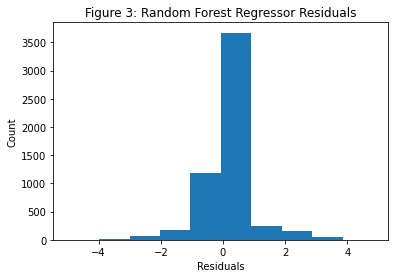

In [4]:
residuals = y_test['Response'] - y_test_pred
plt.hist(residuals)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Figure 3: Random Forest Regressor Residuals')
plt.show()

In [5]:
print('Figure 4 Average PRPM for Pass Rush Outcomes')
# Group the data by Outcomes and compute the mean of the randomforest_prpm column
grouped_data = data_with_rfprpm.groupby('Outcomes')['randomforest_prpm'].mean()

# Create a PrettyTable object
table = PrettyTable()

# Set the column names and align the text
table.field_names = ["Outcomes", "Mean randomforest_prpm"]
table.align = "l"

# Add the rows to the table
for outcomes, value in grouped_data.items():
    table.add_row([outcomes, value])

# Print the table
print(table)


Figure 4 Average PRPM for Pass Rush Outcomes
+----------+------------------------+
| Outcomes | Mean randomforest_prpm |
+----------+------------------------+
| hit      | 2.5787343263561895     |
| hurry    | 1.860932710979182      |
| none     | 0.16377129551095937    |
| sack     | 3.9766429773698473     |
+----------+------------------------+


**2.3 Player Rankings**

Using the PRPM we are able to evaluate pass rushers based on their average PRPM per rush. The top ranking pass rushers for Defensive Ends, Defensive Tackles, and Outside Line Backers are shown with their pass rush stats in figures 5, 6, and 7, respectively. 

In [6]:
#DE Rankings
# Extract the top 10 rows
top_rows = DE_stats[['name','randomforest_prpm', 'sack_rank', 'hits_rank', 'hurry_rank']].head(10)

# Create a PrettyTable object
table = PrettyTable()

# Set the column names and align the text
table.field_names = ["Name", "randomforest_prpm", "sack_rank", "hits_rank", "hurry_rank"]
table.align = "l"

# Add the rows to the table
for _, row in top_rows.iterrows():
    table.add_row([row['name'], row['randomforest_prpm'], row['sack_rank'], row['hits_rank'], row['hurry_rank']])

# Print the table
print('Figure 5: Defensive End Pass Rush Rankings According to PRPM')
print(table)

Figure 5: Defensive End Pass Rush Rankings According to PRPM
+--------------------+--------------------+-----------+-----------+------------+
| Name               | randomforest_prpm  | sack_rank | hits_rank | hurry_rank |
+--------------------+--------------------+-----------+-----------+------------+
| Myles Garrett      | 0.9454335899486322 | 1         | 5         | 2          |
| Trey Hendrickson   | 0.9386791640421159 | 2         | 26        | 4          |
| Yannick Ngakoue    | 0.7575349290552313 | 42        | 33        | 19         |
| Randy Gregory      | 0.7377045067554328 | 17        | 13        | 22         |
| Nick Bosa          | 0.7137393221381826 | 8         | 6         | 47         |
| A.J. Epenesa       | 0.7103339936983999 | 791       | 46        | 92         |
| Jadeveon Clowney   | 0.7015121701429551 | 27        | 59        | 25         |
| Takkarist McKinley | 0.6956612073533822 | 81        | 71        | 108        |
| Alton Robinson     | 0.6941552462586388 | 139 

In [7]:
#DT Rankings
# Extract the top 10 rows
top_rows = DT_stats[['name','randomforest_prpm', 'sack_rank', 'hits_rank', 'hurry_rank']].head(10)

# Create a PrettyTable object
table = PrettyTable()

# Set the column names and align the text
table.field_names = ["Name", "randomforest_prpm", "sack_rank", "hits_rank", "hurry_rank"]
table.align = "l"

# Add the rows to the table
for _, row in top_rows.iterrows():
    table.add_row([row['name'], row['randomforest_prpm'], row['sack_rank'], row['hits_rank'], row['hurry_rank']])

# Print the table
print('Figure 6: Defensive Tackle Pass Rush Rankings According to PRPM')
print(table)

Figure 6: Defensive Tackle Pass Rush Rankings According to PRPM
+-------------------+--------------------+-----------+-----------+------------+
| Name              | randomforest_prpm  | sack_rank | hits_rank | hurry_rank |
+-------------------+--------------------+-----------+-----------+------------+
| Javon Hargrave    | 0.6917376014760419 | 28        | 35        | 46         |
| Aaron Donald      | 0.5730659402608983 | 12        | 9         | 12         |
| Ross Blacklock    | 0.5637229872483265 | 214       | 258       | 132        |
| Jonathan Allen    | 0.5240543923949517 | 13        | 8         | 17         |
| Solomon Thomas    | 0.5239973160968445 | 53        | 17        | 81         |
| Akiem Hicks       | 0.509143646778355  | 59        | 83        | 218        |
| Quinton Jefferson | 0.4970562411018567 | 60        | 31        | 130        |
| Chris Jones       | 0.4903789558967623 | 73        | 84        | 30         |
| Jeffery Simmons   | 0.4730800647761049 | 33        | 7

In [8]:
#OLB Rankings
# Extract the top 10 rows
top_rows = OLB_stats[['name','randomforest_prpm', 'sack_rank', 'hits_rank', 'hurry_rank']].head(10)

# Create a PrettyTable object
table = PrettyTable()

# Set the column names and align the text
table.field_names = ["Name", "randomforest_prpm", "sack_rank", "hits_rank", "hurry_rank"]
table.align = "l"

# Add the rows to the table
for _, row in top_rows.iterrows():
    table.add_row([row['name'], row['randomforest_prpm'], row['sack_rank'], row['hits_rank'], row['hurry_rank']])

# Print the table
print('Figure 7: Outside Line Backer Pass Rush Rankings According to PRPM')
print(table)

Figure 7: Outside Line Backer Pass Rush Rankings According to PRPM
+---------------------+--------------------+-----------+-----------+------------+
| Name                | randomforest_prpm  | sack_rank | hits_rank | hurry_rank |
+---------------------+--------------------+-----------+-----------+------------+
| Frankie Luvu        | 1.0134258575682198 | 129       | 230       | 163        |
| Micah Parsons       | 0.9207736282750643 | 48        | 43        | 41         |
| Harold Landry       | 0.8019260598229515 | 3         | 23        | 9          |
| K'Lavon Chaisson    | 0.7709364778237658 | 242       | 120       | 135        |
| Olasunkanmi Adeniyi | 0.7585257596043465 | 43        | 53        | 285        |
| Julian Okwara       | 0.7529146361278171 | 94        | 92        | 144        |
| Romeo Okwara        | 0.7280511575548057 | 232       | 255       | 59         |
| Rashan Gary         | 0.7217404398682871 | 21        | 3         | 10         |
| Von Miller          | 0.69728

As shown in the data, the PRPM rankings identify many elite players such as Myles Garret, Trey Hendrickson, Nick Bosa, and Maxx Crosby at defensive end, Javon Hargrave, Aaron Donald, and Jonothan Allen at defensive tackle, and Micah Parsons, Harold Landry, Von Miller, and Josh Allen at outside linebacker. Another relevant observation is PRPM scores between postitions. Defensive Ends and and Outside Linebackers create more pressure than Defensive Tackles according to our metric. Intuitively, this makes sense and stresses the importance of having talented edge rushers for a great pass rush. One unexpected result is the presence of several less know players in the top rankings by average PRPM. These are discussed in 3.2 Future Work and Improvements.

# **3. Discussion**

**3.1 Implications**

While further analysis and testing is required. We believe that the PRPM proposed in this paper fills a need for an auto-calculated metric that can evaluate a pass rushers performance independent of stats such as hurries, hits, and sacks. 

The model used for generating the PRPM shows high accuracy (Figure 3), and succesfully identifies players who are well-known good pass rushers (Figures 5, 6, and 7).

This metric can be used to rank pass rushers within their position, and can be expanded to evalute, offensive lineman, quarterbacks, and the effectiveness of offensive or defensive schemes ability to prevent or create pressure. 

**3.2 Future Work and Improvements**

One limitation of this work is that information is potentially lost when transforming the raw positional data into PM1-6 so that it can be handled by the Random Forest Regressor. A potential improvement would be to use a Long-Short Term Memory Nueral Network (LSTM) for regression instead of a Random Forest Regressor. An LSTM would be able to handle the raw positional data in its input layers. We considered this method, but felt more comfortable with our knowledge and understanding of Random Forest Regressors and upon evaluating our model believed that it provides a high enough accuarcy and low enough bias. 

Another limitation is the amount of data provided by the contest. The data provided is only weeks 1-8 of the NFL season. Ideally, we would like to train the model on an entire season's worth of data. We believe this could increase the models accuracy, reducing the test_MSE and residual values.

The last improvement we would make to this model is investigating the presence of certain players atop the PRPM rankings. For example Frankie Luvu, based on the given data, is ranked 129th in sacks, 230th in hits, and 163rd in hurries, but is the highest rated OLB over players like Micah Parsons and Harold Landry. We belive that this could be because of some high outlying values. We could correct for this by ranking players based on their median PRPM score. 

**3.3 Limitations of PRPM**

There are two main limitations to the PRPM metric. 

**1. PRPM has no way to negatively grade players:**

Unlike maunal pff grades which range from -2.5 to 2.5, PRPM ranges from 0-5. Zero meaning that the player applied no pressure during the play and 5 meaning that the player applied lots of pressure, likely resulting in a sack. PRPM can't negatively grade players if they miss out on a play that they were supposed to make. 

**2. PRPM doesn't take into account players ability to finish on the QB:**

PRPM grades pressure based on a players movements– proximity to the quarterback and speed. This doesn't take into account a pass rusher's ability to finish on the quarterback, getting him to the ground, or other things like batted balls at the line of scrimmage. 


## **4 References**

1.	https://www.pff.com/news/pro-how-pff-grades-pass-rushers
2.	https://www.pff.com/news/pro-signature-stat-spotlight-pass-rushing-productivity
3.	https://www.espn.com/nfl/story?id=34536376&_slug_=2022-nfl-pass-rushing-run-stopping-blocking-leaderboard-win-rate-rankings-top-players-teams
4.	https://theanalyst.com/na/2021/08/measuring-the-best-at-pressuring-the-quarterback-and-pass-blocking-in-the-nfl/
